In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)

# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Compute Steady State from time series data

In [3]:
def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


In [4]:
# load the transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

In [5]:
# compute steady state
steadyStateEV = computeSteadyStateEV(P_allCountries_Bayes)

## Illustrations

In [6]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [7]:
# plot the distribution at earlier times
[hist1800,binEdges ] = np.histogram(timeSeries[timeSeries['year']==1800]['polity2'],np.arange(-10,12))
[hist1900,binEdges ] = np.histogram(timeSeries[timeSeries['year']==1900]['polity2'],np.arange(-10,12))
[hist2000,binEdges ] = np.histogram(timeSeries[timeSeries['year']==2000]['polity2'],np.arange(-10,12))
[hist2018,binEdges ] = np.histogram(timeSeries[timeSeries['year']==2018]['polity2'],np.arange(-10,12))

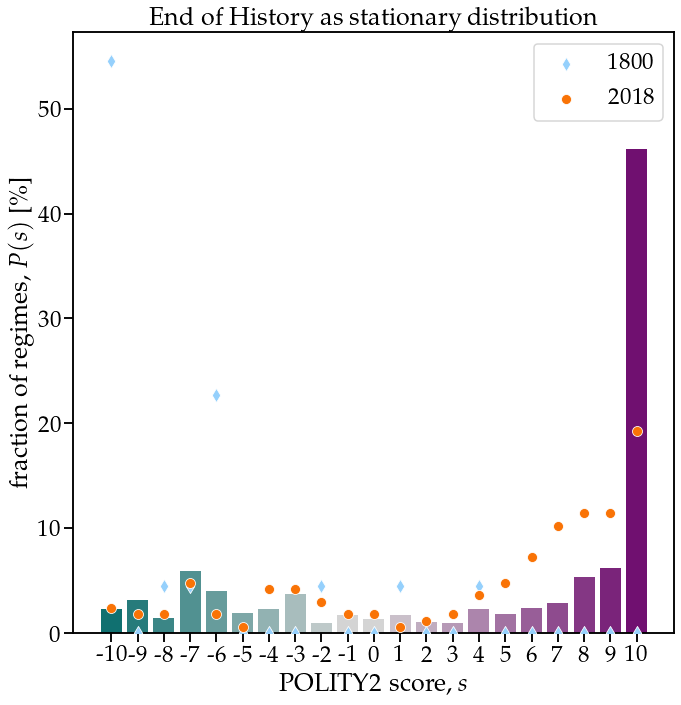

In [8]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV
steadyState['regime'] = np.arange(-10,11,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)


sns.scatterplot(x=np.arange(0,21),y=100*hist1800/np.sum(hist1800),marker='d',color=sns.xkcd_rgb['light blue'], s=100,zorder=10,label=r'1800')
sns.scatterplot(x=np.arange(0,21),y=100*hist2018/np.sum(hist2018),marker='o',color=sns.xkcd_rgb['orange'], s=100, zorder=11,label=r'2018')
plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')




In [16]:
def distributionsForYear(timeSeriesData,year):
    currentScores=timeSeriesData[timeSeriesData['year']==year]['polity2']
    [countsYear,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
    densityYear = countsYear/np.sum(countsYear)
    return(densityYear)



In [17]:
currentScores=timeSeries[timeSeries['year']==2018]['polity2']
[counts2018,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
density2018 = counts2018/np.sum(counts2018)

In [18]:
#np.linalg.inv(P_allCountries)

(P_allCountries.transpose())*P_allCountries

array([[9.52634488e-01, 1.83177142e-05, 2.17751067e-05, 9.87233833e-06,
        3.34652422e-06, 0.00000000e+00, 1.92561355e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.79272745e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.83177142e-05, 8.74919243e-01, 5.58545750e-04, 4.74809896e-05,
        3.25153554e-05, 1.15677145e-05, 1.57160337e-05, 3.64204523e-06,
        0.00000000e+00, 0.00000000e+00, 2.65325300e-05, 0.00000000e+00,
        4.99064255e-05, 3.11915159e-06, 0.00000000e+00, 1.73976583e-06,
        9.40785399e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.17751067e-05, 5.58545750e-04, 7.80962683e-01, 2.42647153e-04,
        3.60756608e-05, 1.28343344e-05, 2.49098264e-06, 6.46533610e-06,
        0.00000000e+00, 1.10741971e-05, 2.45314493e-05, 0.00000000e+00,
        5.5370

In [24]:
# iterate over years 

tMax = 750

# forward
x=np.zeros((21,tMax))
x[:,0]=density2018
for t in np.arange(tMax-1):
    x[:,t+1]= x[:,t].dot(P_allCountries_Bayes)

# # backwards
# backTransition=P_allCountries.transpose()
# xBack=np.zeros((21,tMax))
# xBack[:,0]=density2018
# for t in np.arange(tMax-1):
#     xBack[:,t+1]= xBack[:,t].dot(backTransition)

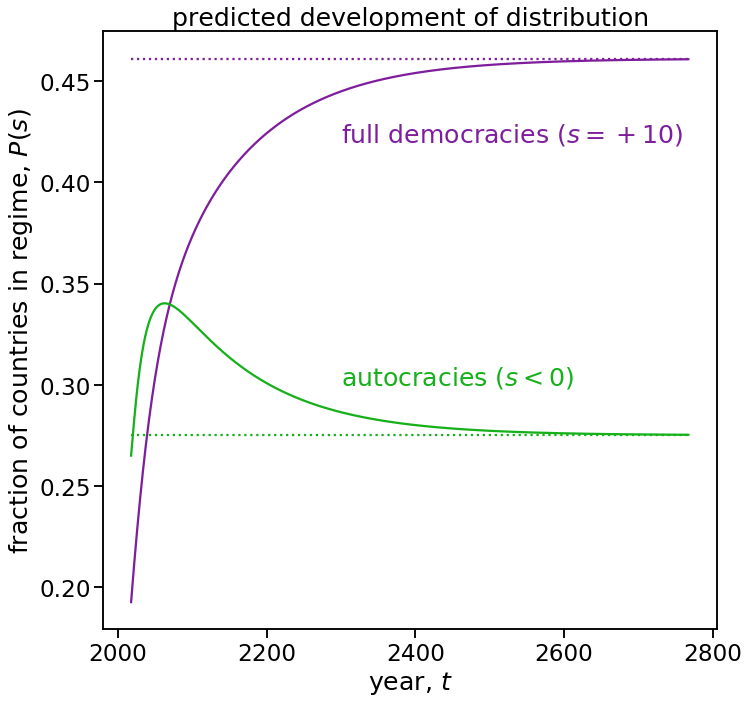

In [28]:
plt.figure(figsize=(11,11))


plt.plot(np.arange(2018, 2018+ tMax),x[20,:],c=sns.xkcd_rgb['purple'])

autocraty = np.sum(x[0:10,:],axis=0)
plt.plot(np.arange(2018, 2018+ tMax),autocraty,c=sns.xkcd_rgb['green'])


# partialDemocracy = np.sum(x[10:19,:],axis=0)
# plt.plot(np.arange(2018, 2018+ tMax),partialDemocracy,c=sns.xkcd_rgb['light purple'])

# anocracy = np.sum(x[6:16,:],axis=0)
# plt.plot(np.arange(2018, 2018+ tMax),anocracy,c=sns.xkcd_rgb['red'])
# plt.plot(np.arange(2018, 2018+ tMax),x[0,:])
plt.hlines(y=steadyStateB[20],xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['purple'])
#plt.hlines(y=0.99*steadyState[20],xmin=2018,xmax=2018+tMax,linestyles='dotted')

plt.hlines(y=np.sum(steadyStateB[0:10]),xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['green'])


# add the historical data
years = np.append(np.arange(1800,2018,20),2018)
historicDistributions = np.zeros((len(years),3))
i=0
for y in years:
    densityThisYear = distributionsForYear(timeSeries,y)
    # save the data for full democracies
    historicDistributions[i,0] = densityThisYear[20]
    # and for autocracies
    historicDistributions[i,1] = np.sum(densityThisYear[0:10])
    # and for partial democracies
    historicDistributions[i,2] = np.sum(densityThisYear[10:19])
    i=i+1

# plt.scatter(years,historicDistributions[:,0],color=sns.xkcd_rgb['purple'])
# plt.scatter(years,historicDistributions[:,1],color=sns.xkcd_rgb['green'])
# #plt.scatter(years,historicDistributions[:,2],color=sns.xkcd_rgb['light purple'])

plt.text(x=2300,y=0.3,s=r'autocracies ($s<0$)',color=sns.xkcd_rgb['green'])
plt.text(x=2300,y=0.42,s=r'full democracies ($s=+10$)',color=sns.xkcd_rgb['purple'])

plt.xlabel(r'year, $t$')
plt.ylabel(r'fraction of countries in regime, $P(s)$')
plt.title('predicted development of distribution')
plt.savefig('./figures/predictedDevelopment_v3.pdf')

In [37]:
np.append(years,2018)

array([1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000,
       2018])

In [31]:
np.where(autocraty-x[20,:]<0)[0][0]+2018

2070

In [32]:
np.max(autocraty)

0.3402494968249496

In [33]:
np.argmax(autocraty)+2018

2063

In [47]:
np.where((steadyStateB[20]-x[20,:])<0.01)[0][0]

342